# Acoustic Ranging

## Imports

In [1]:
# Python Standard Library
import getopt
import os
import sys
import math
import time
import collections
import random

# IPython
from IPython.display import display

# pandas
import pandas as pd
pd.set_option("display.max_rows", 10000)
pd.set_option("display.max_columns", 10000)

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt                       
import matplotlib.mlab as mlab
from matplotlib.ticker import MultipleLocator

# seaborn
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()

# NumPy
import numpy as np                                    

# SciPy
import scipy as sp
from scipy.io import wavfile
from scipy import signal
from scipy.signal import butter, buttord, firwin, firwin2, lfilter, lfilter_zi, filtfilt, freqz, argrelmax

<Figure size 432x288 with 0 Axes>

## Constants & Global Variables

In [2]:
input_data_directory = "data"
output_data_directory = "out"

sampling_rate = 44100
nyquist_frequency = sampling_rate/2
tone_duration = 0.05
low_cut_frequency = 2000
high_cut_frequency = 6000

def normalize_data(data):
    return data/0x7FFF

def bandpass_filter(data,
                    low_cut_frequency,
                    high_cut_frequency,
                    sampling_rate=44100,
                    filter_type=None,
                    filter_order=None,
                    passband_edge=1000,
                    max_passband_loss=3,
                    min_stopband_attenuation=20,
                    return_parameters=False,
                    verbose=True):
    
    if filter_type is None or filter_type == "none":
        return data
    
    nyquist_frequency = sampling_rate/2
    a = [1.0]
    
    if filter_type == "butter":
        b, a = butter(filter_order,
                      [low_cut_frequency/nyquist_frequency,
                       high_cut_frequency/nyquist_frequency],
                      btype="band")
    elif filter_type == "buttord":    
        N, Wn = buttord([low_cut_frequency/nyquist_frequency,
                        high_cut_frequency/nyquist_frequency],
                       [(low_cut_frequency-passband_edge)/nyquist_frequency,
                        (high_cut_frequency+passband_edge)/nyquist_frequency], 
                       max_passband_loss,
                       min_stopband_attenuation,
                       False)
        if verbose:
            print("Buttord Order: ", N," Critical Frequencies: ", Wn)
        b, a = butter(N, Wn, btype="band")
    elif filter_type == "firwin":
        b = firwin(filter_order,
                   [low_cut_frequency,
                    high_cut_frequency],
                   nyq=nyquist_frequency,
                   pass_zero=False)
    elif filter_type == "firwin2":
        b = signal.firwin2(filter_order,
                   [0.0,
                    (low_cut_frequency-passband_edge)/nyquist_frequency,
                    low_cut_frequency/nyquist_frequency,
                    high_cut_frequency/nyquist_frequency,
                    (high_cut_frequency+passband_edge)/nyquist_frequency,
                    1.0],
                   [0.0, 0.0, 1.0, 1.0, 0.0, 0.0])
    else:
        raise NameError("Unsupported Filter Type")
    
    if return_parameters:
        return b, a

    if filter_type == "butter" or filter_type == "buttord":
        if verbose:
            y = %time filtfilt(b, a, data)
        else:
            y = filtfilt(b, a, data)
    elif filter_type == "firwin" or filter_type == "firwin2":
        zi = lfilter_zi(b, a)
        if verbose:
            y, zf = %time lfilter(b, a, data, zi=zi*data[0])
        else:
            y, zf = lfilter(b, a, data, zi=zi*data[0])
    return y

## Tone Generation

In [3]:
def sine_wave_tone(frequency, duration, sampling_rate):
    return np.sin(2 * math.pi * np.arange(math.ceil(sampling_rate * duration)) * frequency / sampling_rate) * 0x7FFF

def linear_chirp_tone(frequency0, frequency1, duration, phase0=0, sampling_rate=44100):
    num_samples = math.ceil(sampling_rate * duration);
    k = (frequency1 - frequency0)/num_samples
    return np.sin(phase0+2*math.pi*(np.arange(num_samples)*frequency0/sampling_rate+k/2*np.arange(num_samples)**2/sampling_rate)) * 0x7FFF

### Visualize Tone

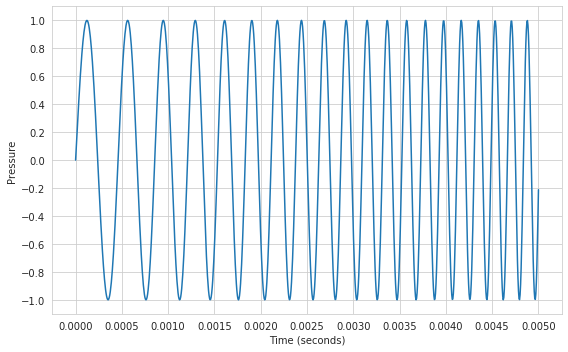

In [4]:
tone_data = linear_chirp_tone(2000, 6000, 0.005, sampling_rate=sampling_rate*4)
tone_data = normalize_data(tone_data)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(np.linspace(0, 0.005, num=math.ceil(0.005*sampling_rate*4)),
        tone_data)

ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Pressure")

ax.xaxis.set_major_locator(MultipleLocator(0.0005))
ax.yaxis.set_major_locator(MultipleLocator(0.2))

plt.tight_layout()
fig.savefig(output_data_directory+"/plot-linear_chirp_tone.pdf", dpi=300)
plt.show()

## Filters

Buttord Order:  8  Critical Frequencies:  [0.09068911 0.27214599]


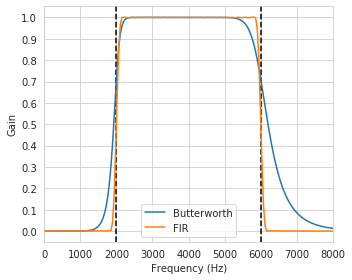

In [5]:
fig, ax = plt.subplots(figsize=(5,4))

ax.axvline(low_cut_frequency, color='black', linestyle="--")
ax.axvline(high_cut_frequency, color='black', linestyle="--")
ax.set_xlim(0, high_cut_frequency+low_cut_frequency)

b, a = bandpass_filter(None,
                       low_cut_frequency,
                       high_cut_frequency,
                       filter_type="buttord",
                       return_parameters=True)
w, h = freqz(b, a)
ax.plot((nyquist_frequency/np.pi) * w, abs(h), label="Butterworth", linestyle="-")

filter_order=500
b, a = bandpass_filter(None,
                       low_cut_frequency,
                       high_cut_frequency,
                       filter_type="firwin",
                       filter_order=filter_order,
                       return_parameters=True)
w, h = freqz(b, a)
ax.plot((nyquist_frequency/np.pi) * w, abs(h), label="FIR", linestyle="-")

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Gain')

ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.yaxis.set_major_locator(MultipleLocator(0.1))

ax.legend()

fig.tight_layout()
fig.savefig(output_data_directory+"/plot-filter_frequency_response.pdf", dpi=300)
plt.show()

## Helper Functions

In [6]:
def generate_tone(tone_frequency0, 
                  tone_frequency1,
                  tone_duration,
                  sampling_rate,
                  filter_type,
                  filter_order,
                  save=True,
                  normalize=True,
                  path=input_data_directory+"/audio/tone.wav"):
    tone_data = linear_chirp_tone(tone_frequency0, tone_frequency1, tone_duration, sampling_rate)
    if save:
        wavfile.write(path, sampling_rate, tone_data.astype(np.int16))
    if(normalize):
        data = normalize_data(tone_data)
    else:
        data = tone_data    
    return bandpass_filter(data,
                       tone_frequency0,
                       tone_frequency1,
                       filter_type=filter_type,
                       filter_order=filter_order)

def load_sample(path,
                tone_frequency0,
                tone_frequency1,
                filter_type,
                filter_order,
                normalize=True):
    sampling_rate, sample_data = wavfile.read(path)
    if(normalize):
        data = normalize_data(sample_data)
    else:
        data = sample_data
    return sampling_rate, bandpass_filter(data,
                                    tone_frequency0,
                                    tone_frequency1,
                                    filter_type=filter_type,
                                    filter_order=filter_order)
   
def tone_correlation(sample_data, tone_frequency0, tone_frequency1, tone_data):
    correlation = sp.correlate(sample_data, tone_data, "valid")
    return correlation

def tone_recognition(sample_data, sampling_rate, duration):
    last_index = 0
    tones = []
    tone_candidates = argrelmax(sample_data, order=math.ceil(duration*sampling_rate/2))[0]
    for candidate in tone_candidates:
        tones.append((candidate, sample_data[candidate]))
    tones.sort(key=lambda tup: tup[1])
    tones.reverse()
    
    return tones

def compute_etoa(tones, sampling_rate):
    if len(tones) < 2:
        raise NameError("Insufficient Tones Detected")
    else:
        return abs(tones[0][0]-tones[1][0])/sampling_rate
    
def compute_distance(etoa_a, etoa_b, d_aa, d_bb, c=340.29):
    return (c/2) * (etoa_a - etoa_b) + (d_aa + d_bb)

def device_distance(self_distance_a,
                    self_distance_b,
                    device_a_path,
                    device_b_path,
                    tone_frequency0,
                    tone_frequency1,
                    tone_duration,
                    sampling_rate,
                    sample_filter_type=None,
                    sample_filter_order=None,
                    tone_filter_type=None,
                    tone_filter_order=None,
                    normalize_tone=True,
                    normalize_samples=True,
                    verbose=False):

    tone_data = generate_tone(tone_frequency0,
                              tone_frequency1,
                              tone_duration,
                              sampling_rate,
                              tone_filter_type,
                              tone_filter_order,
                              normalize=normalize_tone)
    if verbose:
        plt.figure()
        plt.plot(tone_data)
    
    
    if verbose:
        print("Device A Sample:", device_a_path)
        print("Device B Sample:", device_b_path)
    
    
    device_a_sampling_rate, device_a_sample_data = load_sample(device_a_path,
                                                             tone_frequency0,
                                                             tone_frequency1,
                                                             sample_filter_type,
                                                             sample_filter_order,
                                                             normalize=normalize_samples)
    if verbose:
        plt.figure()
        plt.suptitle("Device A Waveform", fontsize=16)
        plt.plot(device_a_sample_data)
    
    device_b_sampling_rate, device_b_sample_data = load_sample(device_b_path,
                                                             tone_frequency0,
                                                             tone_frequency1,
                                                             sample_filter_type,
                                                             sample_filter_order,
                                                             normalize=normalize_samples)
    if verbose:
        plt.figure()
        plt.suptitle("Device B Waveform", fontsize=16)
        plt.plot(device_b_sample_data)
    
    
    device_a_correlation = tone_correlation(device_a_sample_data,
                                            tone_frequency0,
                                            tone_frequency1,
                                            tone_data)
    if verbose:
        plt.figure()
        plt.suptitle("Device A Correlation", fontsize=16)
        plt.plot(device_a_correlation)
    
    device_b_correlation = tone_correlation(device_b_sample_data,
                                            tone_frequency0,
                                            tone_frequency1,
                                            tone_data)
    if verbose:
        plt.figure()
        plt.suptitle("Device B Correlation", fontsize=16)
        plt.plot(device_b_correlation)
    
    
    device_a_tones = tone_recognition(device_a_correlation, sampling_rate, tone_duration)
    if verbose:
        print("Device A")
        print("A total of",len(device_a_tones),"tones were detected.")
        print("The best candidates are (",
              device_a_tones[0][0],",",device_a_tones[0][1],") and (",
              device_a_tones[1][0],",",device_a_tones[1][1],")")  
        print("A total of",len(device_a_tones),"tones were detected.")    
    
    device_b_tones = tone_recognition(device_b_correlation, sampling_rate, tone_duration)
    if verbose: 
        print("Device B")
        print("The best candidates are (",
              device_b_tones[0][0],",",device_b_tones[0][1],") and (",
              device_b_tones[1][0],",",device_b_tones[1][1],")")  
        print("A total of",len(device_b_tones),"tones were detected.")
    
    
    etoa_a = compute_etoa(device_a_tones, sampling_rate)
    if verbose: 
        print("Device A ETOA:",device_a_etoa)
        
    etoa_b = compute_etoa(device_b_tones, sampling_rate)
    if verbose:
        print("Device B ETOA:",device_b_etoa)

    
    distance = compute_distance(etoa_a, etoa_b, self_distance_a, self_distance_b)
    if verbose:
        print("Distance between devices in meters:", distance)
    return distance

## Trials

In [7]:
self_distance_a = 0.04
self_distance_b = 0.04
trials = [
            {"actual_distance": 0.5,
             "self_distance_a": self_distance_a,
             "self_distance_b": self_distance_b,
             "device_a_sample_path": input_data_directory+"/audio/trial-0-chirp-0.5m-da.wav",
             "device_b_sample_path": input_data_directory+"/audio/trial-0-chirp-0.5m-db.wav"},
    
            {"actual_distance": 0.5,
             "self_distance_a": self_distance_a,
             "self_distance_b": self_distance_b,
             "device_a_sample_path": input_data_directory+"/audio/trial-1-chirp-0.5m-da.wav",
             "device_b_sample_path": input_data_directory+"/audio/trial-1-chirp-0.5m-db.wav"},
    
            {"actual_distance": 0.5,
             "self_distance_a": self_distance_a,
             "self_distance_b": self_distance_b,
             "device_a_sample_path": input_data_directory+"/audio/trial-2-chirp-0.5m-da.wav",
             "device_b_sample_path": input_data_directory+"/audio/trial-2-chirp-0.5m-db.wav"},
    
            {"actual_distance": 1,
             "self_distance_a": self_distance_a,
             "self_distance_b": self_distance_b,
             "device_a_sample_path": input_data_directory+"/audio/trial-0-chirp-1m-da.wav",
             "device_b_sample_path": input_data_directory+"/audio/trial-0-chirp-1m-db.wav"},
    
            {"actual_distance": 1,
             "self_distance_a": self_distance_a,
             "self_distance_b": self_distance_b,
             "device_a_sample_path": input_data_directory+"/audio/trial-1-chirp-1m-da.wav",
             "device_b_sample_path": input_data_directory+"/audio/trial-1-chirp-1m-db.wav"},
    
            {"actual_distance": 1,
             "self_distance_a": self_distance_a,
             "self_distance_b": self_distance_b,
             "device_a_sample_path": input_data_directory+"/audio/trial-2-chirp-1m-da.wav",
             "device_b_sample_path": input_data_directory+"/audio/trial-2-chirp-1m-db.wav"},
]

results = []
sample_filter_types = ["firwin", "buttord"]
for trial in trials:
    for sample_filter_type in sample_filter_types:
        tone_filter_type = sample_filter_type
        print("Trial Files:",trial["device_a_sample_path"], "and", trial["device_b_sample_path"])
        print("Actual distance between devices in meters:", trial["actual_distance"])
        estimated_distance = device_distance(trial["self_distance_a"],
                                             trial["self_distance_b"],
                                             trial["device_a_sample_path"],
                                             trial["device_b_sample_path"],
                                             low_cut_frequency,
                                             high_cut_frequency,
                                             tone_duration,
                                             sampling_rate,
                                             sample_filter_type=sample_filter_type,
                                             sample_filter_order=filter_order,
                                             tone_filter_type=tone_filter_type,
                                             tone_filter_order=filter_order)
        print("Estimated distance between devices in meters:", estimated_distance)
        absolute_error = abs(estimated_distance-trial["actual_distance"])
        print("Absolute error:",absolute_error)
        relative_error = absolute_error/trial["actual_distance"]*100
        print("Relative error:", relative_error)
        results.append({"self_distance_a": trial["self_distance_a"],
                        "self_distance_b": trial["self_distance_b"],
                        "device_a_sample_path": trial["device_a_sample_path"],
                        "device_b_sample_path": trial["device_b_sample_path"],
                        "tone_frequency0": low_cut_frequency,
                        "tone_frequency1": high_cut_frequency,
                        "tone_duration": tone_duration,
                        "sampling_rate": sampling_rate,
                        "sample_filter_type": sample_filter_type,
                        "actual_distance": trial["actual_distance"],
                        "estimated_distance": estimated_distance,
                        "absolute_error": absolute_error,
                        "relative_error": relative_error})            
        print("--------------------------------------------------------------------------------")

Trial Files: data/audio/trial-0-chirp-0.5m-da.wav and data/audio/trial-0-chirp-0.5m-db.wav
Actual distance between devices in meters: 0.5
CPU times: user 2.08 ms, sys: 178 µs, total: 2.26 ms
Wall time: 568 µs
CPU times: user 91 ms, sys: 6.89 ms, total: 97.9 ms
Wall time: 24.5 ms
CPU times: user 93 ms, sys: 1.13 ms, total: 94.1 ms
Wall time: 23.5 ms


/home/pedro/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: scipy.correlate is deprecated and will be removed in SciPy 2.0.0, use numpy.correlate instead


Estimated distance between devices in meters: 0.47353265306121667
Absolute error: 0.02646734693878333
Relative error: 5.293469387756666
--------------------------------------------------------------------------------
Trial Files: data/audio/trial-0-chirp-0.5m-da.wav and data/audio/trial-0-chirp-0.5m-db.wav
Actual distance between devices in meters: 0.5
Buttord Order:  8  Critical Frequencies:  [0.09068911 0.27214599]
CPU times: user 325 µs, sys: 10 µs, total: 335 µs
Wall time: 340 µs
Buttord Order:  8  Critical Frequencies:  [0.09068911 0.27214599]
CPU times: user 9.5 ms, sys: 0 ns, total: 9.5 ms
Wall time: 9.53 ms
Buttord Order:  8  Critical Frequencies:  [0.09068911 0.27214599]
CPU times: user 8.19 ms, sys: 0 ns, total: 8.19 ms
Wall time: 8.19 ms
Estimated distance between devices in meters: 0.5236887755102241
Absolute error: 0.02368877551022408
Relative error: 4.737755102044816
--------------------------------------------------------------------------------
Trial Files: data/audio/t

In [8]:
columns = ["self_distance_a",
           "self_distance_b",
           "device_a_sample_path",
           "device_b_sample_path",
           "tone_frequency0",
           "tone_frequency1",
           "tone_duration",
           "sampling_rate",
           "sample_filter_type",
           "actual_distance",
           "estimated_distance",
           "absolute_error",
           "relative_error"]

results_table = pd.DataFrame.from_dict(results)[columns]
results_table.to_csv(output_data_directory+"/audio_estimated_distance_results.csv")
results_table

,self_distance_a,self_distance_b,device_a_sample_path,device_b_sample_path,tone_frequency0,tone_frequency1,tone_duration,sampling_rate,sample_filter_type,actual_distance,estimated_distance,absolute_error,relative_error
0,0.04,0.04,data/audio/trial-0-chirp-0.5m-da.wav,data/audio/trial-0-chirp-0.5m-db.wav,2000,6000,0.05,44100,firwin,0.5,0.473533,0.026467,5.293469
1,0.04,0.04,data/audio/trial-0-chirp-0.5m-da.wav,data/audio/trial-0-chirp-0.5m-db.wav,2000,6000,0.05,44100,buttord,0.5,0.523689,0.023689,4.737755
2,0.04,0.04,data/audio/trial-1-chirp-0.5m-da.wav,data/audio/trial-1-chirp-0.5m-db.wav,2000,6000,0.05,44100,firwin,0.5,0.504398,0.004398,0.879592
3,0.04,0.04,data/audio/trial-1-chirp-0.5m-da.wav,data/audio/trial-1-chirp-0.5m-db.wav,2000,6000,0.05,44100,buttord,0.5,0.554554,0.054554,10.910816
4,0.04,0.04,data/audio/trial-2-chirp-0.5m-da.wav,data/audio/trial-2-chirp-0.5m-db.wav,2000,6000,0.05,44100,firwin,0.5,0.434951,0.065049,13.009796
5,0.04,0.04,data/audio/trial-2-chirp-0.5m-da.wav,data/audio/trial-2-chirp-0.5m-db.wav,2000,6000,0.05,44100,buttord,0.5,0.434951,0.065049,13.009796
6,0.04,0.04,data/audio/trial-0-chirp-1m-da.wav,data/audio/trial-0-chirp-1m-db.wav,2000,6000,0.05,44100,firwin,1.0,0.998243,0.001757,0.175714
7,0.04,0.04,data/audio/trial-0-chirp-1m-da.wav,data/audio/trial-0-chirp-1m-db.wav,2000,6000,0.05,44100,buttord,1.0,1.102413,0.102413,10.241327
8,0.04,0.04,data/audio/trial-1-chirp-1m-da.wav,data/audio/trial-1-chirp-1m-db.wav,2000,6000,0.05,44100,firwin,1.0,0.955803,0.044197,4.419694
9,0.04,0.04,data/audio/trial-1-chirp-1m-da.wav,data/audio/trial-1-chirp-1m-db.wav,2000,6000,0.05,44100,buttord,1.0,0.959661,0.040339,4.033878


In [9]:
results_table.groupby("sample_filter_type")["absolute_error"].describe()

,count,mean,std,min,25%,50%,75%,max
sample_filter_type,,,,,,,,
buttord,6.0,0.047967,0.034879,0.001757,0.027851,0.047446,0.062425,0.102413
firwin,6.0,0.023938,0.026354,0.001757,0.002417,0.015433,0.039765,0.065049
